# Facility Location Problem (P-median)

We consider the following optimization problem: we have a set of $M$ customers and a set of $N$ potential locations for opening a facility. Given transportation costs between facilities and customers and how many facilities we would like to open ($P$), we need to determine which facilities to open such that the total transportation cost between facilities and customers is minimal, under the constraint that each customer is allocated to only one facility.

### Possible extensions:

$\bullet$ Add different demand for each customer.

$\bullet$ Add cost for opening a facility at each location.

$\bullet$ Different categories of facilities, and customer can have multiple allocations for different facilities.

## Mathematical Modeling

The input of the model is a set of $M$ customers $\{1,\dots,M\}$, a set of $N$ potential locations for facilities $\{1,\dots,N\}$, an $N\times M$ matrix $d$ where $d_{nm}$ is the cost of customer $m$ buying from facility $n$, and the total number of facilities we want to open $P$.

We define a binary variable for the optimization problem: an $N\times M$ matrix $x$ such that $x_{nm}=1$ if customer $m$ is allocated to facility $n$.

The objective function to minimize is the total cost function:
$$
\min_{x} \sum_{n,m} d_{nm}x_{nm}
$$
We have 2 constraints:

(1) Each customer is supplied: $\forall m\in[0,M] \,\,\, \sum_n x_{nm}=1$.

(2) Total number of opened facilities is $P$: $\sum_n\Pi_m (1-x_{nm})=N-P$ (The inner product is zero if the $n-$th facility is not open).

### Alternative modeling
We note that there is an alternative modeling, in which one adds another variable to the model: a binary vector $y$ of size $N$ which indicates which facilities are open. In this formulation the second constraint can be written as $\sum_n y_n=P$ together with an inequality constraint $\forall n,m:\, x_{nm} \leq y_n$. A model which combines equality and inequality constraints will be available in the future.

Note that in this alternative modeling we have a QUBO problem (compared to the formulation above where constraint (2) is polynomial of degree $m$). However, the alternative modelling has more variables to minimize on, and thus refers to more qubits.

### An Example

Let us say we can open facilities in Japan, USA, and France, and we have 4 customers whose costs for buying from these three locations are given. We would like to open in total $P=2$ facilities. The optimization problem is to find where to open the facilities and which customer is allocated to which facility.

We now draw this specific example on a graph. We have $N=3$ locations and $M=4$ customers, where the weights of the edges between them signify the costs:

*Suggestions:*
- Give general problem description and then givens, or provide givens after each mention.
- Standardize writing numbers appearing in sentences out when less than 10. "4" vs "four".

### Necessary Packages

In this demo, besides the `classiq` package, we'll use the following packages:

In [2]:
%%capture
! pip install networkx
! pip install pyomo
! pip install matplotlib

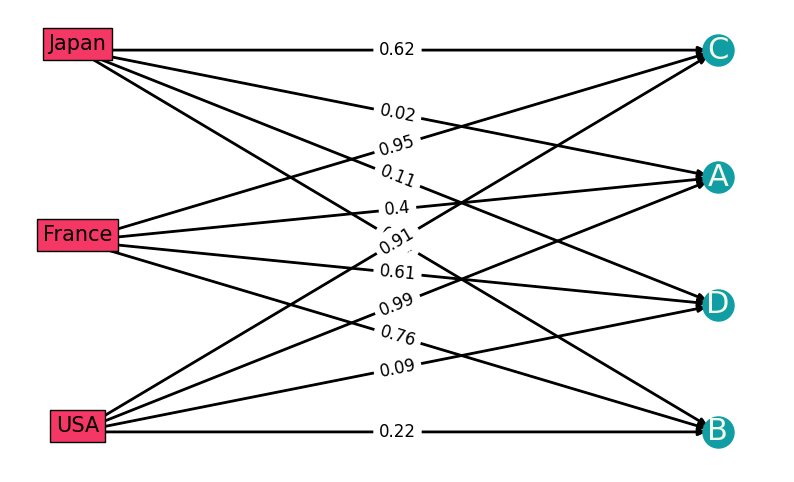

In [3]:
# Import relevant packages

from itertools import product

import matplotlib.pyplot as plt
import networkx as nx  # noqa
import numpy as np
import pandas as pd

# Declare givens from problem statement

Facilities = ["Japan", "USA", "France"]
Customers = ["A", "B", "C", "D"]

N = len(Facilities)  # potential facility count
M = len(Customers)  # customer count
P = 2  # allocated facility count

# costs of customers using facilities
d = np.array(
    [[0.02, 0.14, 0.62, 0.11], [0.99, 0.22, 0.91, 0.09], [0.4, 0.76, 0.95, 0.61]]
)


graph = nx.DiGraph()
graph.add_nodes_from(Facilities + Customers)
for n, m in product(range(N), range(M)):
    graph.add_edges_from([(Facilities[n], Customers[m])], weight=d[n, m])


# Plot the graph
plt.figure(figsize=(10, 6))
left = nx.bipartite.sets(graph)[0]
pos = nx.bipartite_layout(graph, left)

nx.draw_networkx(graph, pos=pos, nodelist=Customers, font_size=22, font_color="None")
nx.draw_networkx_nodes(
    graph, pos, nodelist=Customers, node_color="#119DA4", node_size=500
)
for fa in Facilities:
    x, y = pos[fa]
    plt.text(
        x,
        y,
        s=fa,
        bbox=dict(facecolor="#F43764", alpha=1),
        horizontalalignment="center",
        fontsize=15,
    )

nx.draw_networkx_edges(graph, pos, width=2)
labels = nx.get_edge_attributes(graph, "weight")
nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels, font_size=12)
nx.draw_networkx_labels(
    graph,
    pos,
    labels={co: co for co in Customers},
    font_size=22,
    font_color="#F4F9E9",
)

plt.axis("off")
plt.show()

## Building the Pyomo model from a matrix of distances input

In [4]:
from typing import List, Tuple, cast  # noqa

import pyomo.environ as pyo
from IPython.display import Markdown, display

In [5]:
## We define a function which gets a matrix of costs between customers and potential facilities
## and the number of facilities to open.


def pmedian(cost_mat: np.ndarray, P: int) -> pyo.ConcreteModel:
    model = pyo.ConcreteModel("pmedian")

    N = cost_mat.shape[0]  # potential facility amount
    M = cost_mat.shape[1]  # customer count
    Locations = range(N)
    Customers = range(M)

    model.x = pyo.Var(Locations, Customers, domain=pyo.Binary)

    @model.Constraint(Customers)
    def each_customer_is_supplied_rule(model, m):  # constraint (1)
        return sum(model.x[n, m] for n in Locations) == 1

    def is_location_alocated(n):  # constraint (2)
        return np.prod([(1 - model.x[n, m]) for m in Customers])

    model.num_facilities = pyo.Constraint(
        expr=sum(is_location_alocated(n) for n in Locations) == N - P
    )

    model.cost = pyo.Objective(
        expr=sum(cost_mat[n, m] * model.x[n, m] for n in Locations for m in Customers),
        sense=pyo.minimize,
    )

    return model

## Solving with Classiq

We take a specific example: the one outlined above

In [6]:
pmedian_model = pmedian(d, P)

In [7]:
from classiq import construct_combinatorial_optimization_model
from classiq.applications.combinatorial_optimization import OptimizerConfig, QAOAConfig

qaoa_config = QAOAConfig(num_layers=5, penalty_energy=10)

For the classical optimization part of the QAOA algorithm (`CombinatorialConfig`) we define the maximum number of classical iterations (`max_iteration`) and the $\alpha$-parameter (`alpha_cvar`) for running CVaR-QAOA, an improved variation of the QAOA algorithm [[3](#cvar)]:

In [8]:
optimizer_config = OptimizerConfig(
    max_iteration=30,
    alpha_cvar=1,
)

Lastly, we define the `CombinatorialOptimization` instance which we can use to solve the problem:

In [9]:
qmod = construct_combinatorial_optimization_model(
    pyo_model=pmedian_model,
    qaoa_config=qaoa_config,
    optimizer_config=optimizer_config,
)

We also set the quantum backend we want to execute on:

In [10]:
from classiq import set_execution_preferences
from classiq.execution import ClassiqBackendPreferences, ExecutionPreferences

backend_preferences = ExecutionPreferences(
    backend_preferences=ClassiqBackendPreferences(backend_name="aer_simulator")
)

qmod = set_execution_preferences(qmod, backend_preferences)

In [11]:
with open("facility_location.qmod", "w") as f:
    f.write(qmod)

We define a function that plot solutions

In [12]:
# This function plots the solution in a table and a graph


def plotting_sol(x_sol, cost, is_classic: bool):
    x_sol_to_mat = np.reshape(np.array(x_sol), [N, M])  # vector to matrix
    # opened facilities will be marked in red
    opened_fac_dict = {}
    for fa in range(N):
        if sum(x_sol_to_mat[fa, m] for m in range(M)) > 0:
            opened_fac_dict.update({Facilities[fa]: "background-color: #F43764"})

    # classical or quantum
    if is_classic == True:
        display(Markdown("**CLASSICAL SOLUTION**"))
        print("total cost= ", cost)
    else:
        display(Markdown("**QAOA SOLUTION**"))
        print("total cost= ", cost)

    # plotting in a table
    df = pd.DataFrame(x_sol_to_mat)
    df.columns = Customers
    df.index = Facilities
    plotable = df.style.apply(lambda x: x.index.map(opened_fac_dict))
    display(plotable)

    # plotting in a graph
    graph_sol = nx.DiGraph()
    graph_sol.add_nodes_from(Facilities + Customers)
    for n, m in product(range(N), range(M)):
        if x_sol_to_mat[n, m] > 0:
            graph_sol.add_edges_from([(Facilities[n], Customers[m])], weight=d[n, m])

    plt.figure(figsize=(10, 6))
    left = nx.bipartite.sets(graph_sol, top_nodes=Facilities)[0]
    pos = nx.bipartite_layout(graph_sol, left)

    nx.draw_networkx(
        graph_sol, pos=pos, nodelist=Customers, font_size=22, font_color="None"
    )
    nx.draw_networkx_nodes(
        graph_sol, pos, nodelist=Customers, node_color="#119DA4", node_size=500
    )
    for fa in Facilities:
        x, y = pos[fa]
        if fa in opened_fac_dict.keys():
            plt.text(
                x,
                y,
                s=fa,
                bbox=dict(facecolor="#F43764", alpha=1),
                horizontalalignment="center",
                fontsize=15,
            )
        else:
            plt.text(
                x,
                y,
                s=fa,
                bbox=dict(facecolor="#F4F9E9", alpha=1),
                horizontalalignment="center",
                fontsize=15,
            )

    nx.draw_networkx_edges(graph_sol, pos, width=2)
    labels = nx.get_edge_attributes(graph_sol, "weight")
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels, font_size=12)
    nx.draw_networkx_labels(
        graph_sol,
        pos,
        labels={co: co for co in Customers},
        font_size=22,
        font_color="#F4F9E9",
    )

    plt.axis("off")
    plt.show()

Now we can create a quantum circuit using the `synthesize` command and show it

In [22]:
from classiq import show, synthesize

qprog = synthesize(qmod)
show(qprog)

We now solve the problem using the generated circuit by using the `execute` method:

In [14]:
from classiq import execute

res = execute(qprog).result()

We can check the convergence of the run:

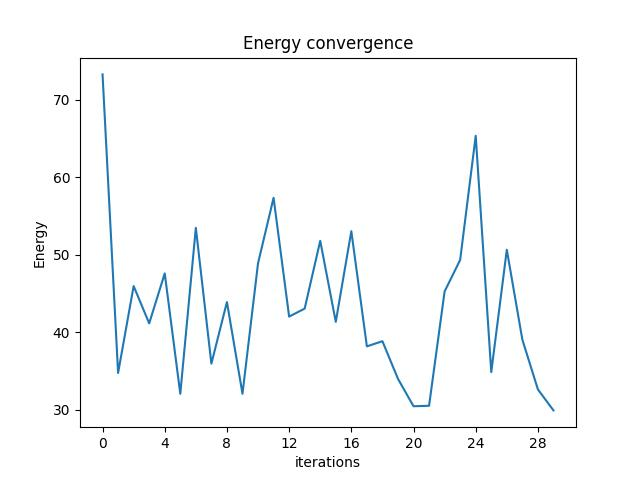

In [15]:
from classiq.execution import VQESolverResult

vqe_result = res[1].value
vqe_result.convergence_graph

## Optimizer statistics

In [16]:
import pandas as pd

optimization_result = pd.DataFrame.from_records(res[0].value)
optimization_result.sort_values(by="cost", ascending=True).head(5)

,probability,cost,solution,count
32,0.003906,0.95,"[1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0]",8
81,0.002441,0.97,"[1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0]",5
118,0.001953,1.16,"[1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0]",4
27,0.003906,1.18,"[1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]",8
157,0.001465,1.22,"[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]",3


array([[<Axes: title={'center': 'cost'}>]], dtype=object)

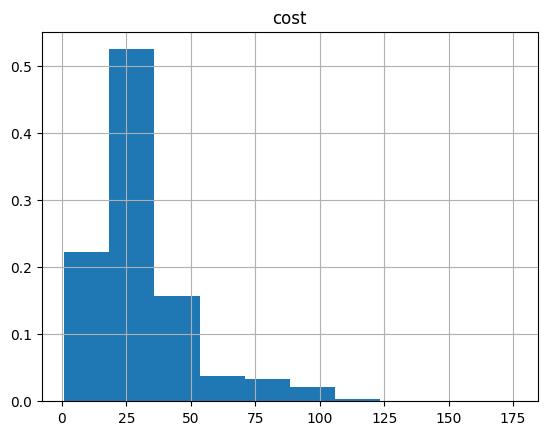

In [17]:
optimization_result.hist("cost", weights=optimization_result["probability"])

## Best solution

We plot the quantum result only if we get the right solution (to avoid problems with printing table and graph).

**QAOA SOLUTION**

total cost=  0.9499999999999922


,A,B,C,D
Japan,1,0,1,0
USA,0,1,0,1
France,0,0,0,0


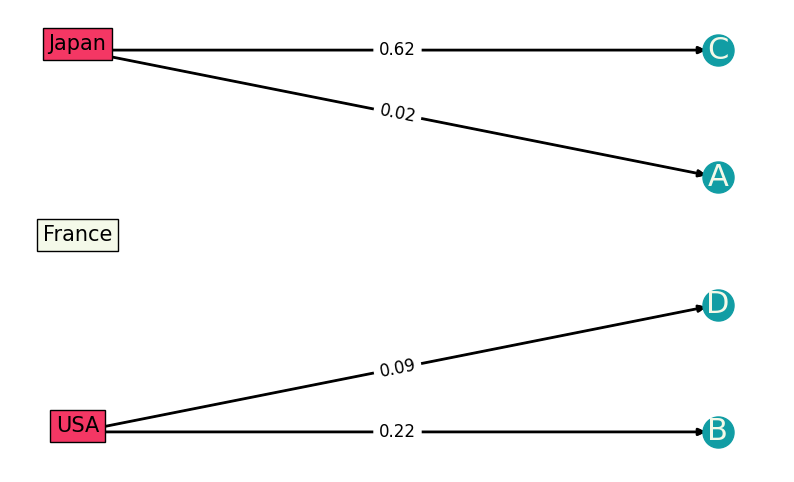

In [18]:
best_solution = optimization_result.loc[optimization_result.cost.idxmin()]

plotting_sol(best_solution.solution, best_solution.cost, is_classic=False)

### Compare to a classical solver

In [19]:
from pyomo.opt import SolverFactory

solver = SolverFactory("couenne")
solver.solve(pmedian_model)

pmedian_model.display()

Model pmedian

  Variables:
    x : Size=12, Index=x_index
        Key    : Lower : Value                  : Upper : Fixed : Stale : Domain
        (0, 0) :     0 :                    1.0 :     1 : False : False : Binary
        (0, 1) :     0 :                    1.0 :     1 : False : False : Binary
        (0, 2) :     0 :                    1.0 :     1 : False : False : Binary
        (0, 3) :     0 :                    0.0 :     1 : False : False : Binary
        (1, 0) :     0 :                    0.0 :     1 : False : False : Binary
        (1, 1) :     0 :  6.846989283059948e-10 :     1 : False : False : Binary
        (1, 2) :     0 :                    0.0 :     1 : False : False : Binary
        (1, 3) :     0 :                    1.0 :     1 : False : False : Binary
        (2, 0) :     0 :                    0.0 :     1 : False : False : Binary
        (2, 1) :     0 : -6.846989283059948e-10 :     1 : False : False : Binary
        (2, 2) :     0 :                    0.0 : 

**CLASSICAL SOLUTION**

total cost=  0.8699999996302625


,A,B,C,D
Japan,1.000000,1.000000,1.000000,0.000000
USA,0.000000,0.000000,0.000000,1.000000
France,0.000000,-0.000000,0.000000,0.000000


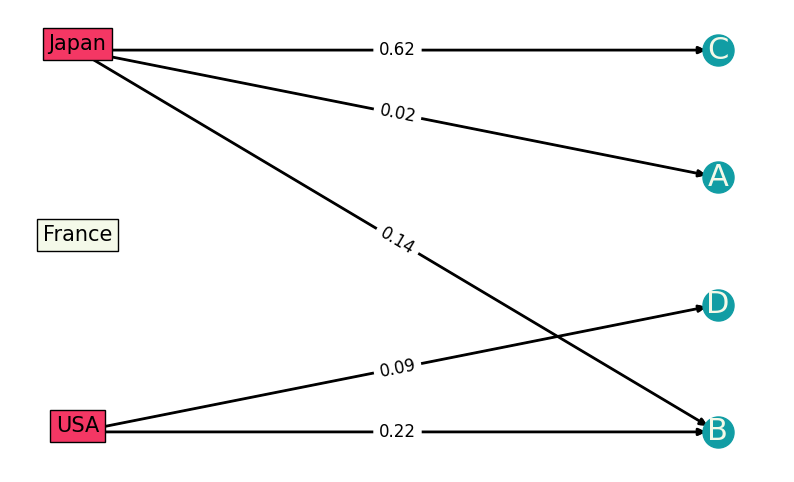

In [20]:
best_classical_solution = np.array(
    [pyo.value(pmedian_model.x[idx]) for idx in np.ndindex(d.shape)]
).reshape(d.shape)

plotting_sol(best_classical_solution, pyo.value(pmedian_model.cost), is_classic=True)